# **Text Generation using RNN and LSTM**

**1 Objective**

The aim of this experiment is to explore text generation using Recurrent Neural Networks (RNNs) and understand the impact of different word representations:

1. One-Hot Encoding
2. Trainable Word Embeddings

Train an RNN model on a dataset of 100 poems and compare the perfor- mance of both encoding techniques.



**2 Dataset**

Use the provided dataset of 100 poems for training your text generation model. The dataset consists of multiple lines of poetry, which will be used to generate text sequences.bold text**

In [ ]:
!pip install torch --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
df = pd.read_csv("poems-100.csv")
df.head()

,text
0,"O my Luve's like a red, red rose\nThat’s newly..."
1,"The rose is red,\nThe violet's blue,\nSugar is..."
2,How do I love thee? Let me count the ways.\nI ...
3,"Had I the heavens' embroidered cloths,\nEnwrou..."
4,"I.\n Enough! we're tired, my heart and I.\n..."


In [ ]:
text = " ".join(df['text'].astype(str).tolist())
print(text[:500])

O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt wi’ the sun:
I will luve thee still, my dear,
While the sands o’ life shall run.

And fare thee well, my only Luve
And fare thee well, a while!
And I will come again, my Luve,
Tho’ it were ten thousand


In [ ]:
# Basic cleaning
text = text.lower()
tokens = text.split()

# Build vocabulary
vocab = Counter(tokens)
vocab = sorted(vocab.keys())

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 6989


In [ ]:
sequence_length = 5

sequences = []
targets = []

for i in range(len(tokens) - sequence_length):
    seq = tokens[i:i+sequence_length]
    target = tokens[i+sequence_length]

    sequences.append([word2idx[w] for w in seq])
    targets.append(word2idx[target])

print("Total sequences:", len(sequences))

Total sequences: 24729


**3 Part 1: One-Hot Encoding Approach**

**3.1 Preprocessing**

• Tokenize the text into words.

• Convert each word into a one-hot vector.


**3.2 Model Architecture**

• Use an RNN and LSTM model.

• The input should be one-hot encoded word sequences.

• Train the model to predict the next word in a sequence.


 **3.3 Implementation Steps**

• Tokenize the dataset and create a vocabulary.

• Convert words into one-hot encoded vectors.

• Define an RNN model using PyTorch.

• Train the model using the dataset.

• Generate text using the trained model.

In [ ]:
class OneHotDataset(Dataset):
    def __init__(self, sequences, targets, vocab_size):
        self.sequences = sequences
        self.targets = targets
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        target = self.targets[idx]

        one_hot_seq = np.zeros((len(seq), self.vocab_size))
        for i, word_idx in enumerate(seq):
            one_hot_seq[i][word_idx] = 1

        return torch.tensor(one_hot_seq, dtype=torch.float32), torch.tensor(target)

In [ ]:
class RNN_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(RNN_OneHot, self).__init__()
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class LSTM_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(LSTM_OneHot, self).__init__()
        self.lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return losses

In [ ]:
batch_size = 64
onehot_dataset = OneHotDataset(sequences, targets, vocab_size)
onehot_loader = DataLoader(onehot_dataset, batch_size=batch_size, shuffle=True)

hidden_size = 128
epochs = 15

print("Training RNN OneHot")
rnn_onehot = RNN_OneHot(vocab_size, hidden_size)
loss_rnn_onehot = train_model(rnn_onehot, onehot_loader, epochs)

print("\nTraining LSTM OneHot")
lstm_onehot = LSTM_OneHot(vocab_size, hidden_size)
loss_lstm_onehot = train_model(lstm_onehot, onehot_loader, epochs)

Training RNN OneHot
Epoch 1, Loss: 7.3874
Epoch 2, Loss: 6.7134
Epoch 3, Loss: 6.3250
Epoch 4, Loss: 5.9418
Epoch 5, Loss: 5.5417
Epoch 6, Loss: 5.1013
Epoch 7, Loss: 4.6423
Epoch 8, Loss: 4.1803
Epoch 9, Loss: 3.7181
Epoch 10, Loss: 3.2738
Epoch 11, Loss: 2.8567
Epoch 12, Loss: 2.4661
Epoch 13, Loss: 2.1128
Epoch 14, Loss: 1.8066
Epoch 15, Loss: 1.5420

Training LSTM OneHot
Epoch 1, Loss: 7.4144
Epoch 2, Loss: 6.8475
Epoch 3, Loss: 6.6683
Epoch 4, Loss: 6.4170
Epoch 5, Loss: 6.0767
Epoch 6, Loss: 5.6618
Epoch 7, Loss: 5.1831
Epoch 8, Loss: 4.6564
Epoch 9, Loss: 4.1282
Epoch 10, Loss: 3.6094
Epoch 11, Loss: 3.1110
Epoch 12, Loss: 2.6258
Epoch 13, Loss: 2.1729
Epoch 14, Loss: 1.7622
Epoch 15, Loss: 1.4025


 **4 Part 2: Trainable Word Embeddings Approach**

**4.1 Preprocessing**

• Tokenize the text into words.

• Convert each word into an index.

**4.2 Model Architecture**

• Use an embedding layer in the RNN model.

• Train the embedding layer along with the model.

• Predict the next word in a sequence.

**4.3 Implementation Steps**

1. Tokenize the dataset and create a vocabulary.

2. Convert words into indexed sequences.

3. Define an RNN model with an embedding layer using PyTorch.

4. Train the model and compare performance with the one-hot encoding method.

5. Generate text using the trained model.

In [ ]:
class IndexDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.targets[idx])

In [ ]:
class RNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(RNN_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class LSTM_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(LSTM_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
index_dataset = IndexDataset(sequences, targets)
index_loader = DataLoader(index_dataset, batch_size=batch_size, shuffle=True)

embed_size = 100

print("Training RNN Embedding")
rnn_embed = RNN_Embedding(vocab_size, embed_size, hidden_size)
loss_rnn_embed = train_model(rnn_embed, index_loader, epochs)

print("\nTraining LSTM Embedding")
lstm_embed = LSTM_Embedding(vocab_size, embed_size, hidden_size)
loss_lstm_embed = train_model(lstm_embed, index_loader, epochs)

Training RNN Embedding
Epoch 1, Loss: 7.3667
Epoch 2, Loss: 6.4465
Epoch 3, Loss: 5.9139
Epoch 4, Loss: 5.3830
Epoch 5, Loss: 4.8447
Epoch 6, Loss: 4.3086
Epoch 7, Loss: 3.7913
Epoch 8, Loss: 3.3035
Epoch 9, Loss: 2.8700
Epoch 10, Loss: 2.4874
Epoch 11, Loss: 2.1459
Epoch 12, Loss: 1.8438
Epoch 13, Loss: 1.5773
Epoch 14, Loss: 1.3462
Epoch 15, Loss: 1.1418

Training LSTM Embedding
Epoch 1, Loss: 7.3552
Epoch 2, Loss: 6.5988
Epoch 3, Loss: 6.1605
Epoch 4, Loss: 5.6631
Epoch 5, Loss: 5.1442
Epoch 6, Loss: 4.6191
Epoch 7, Loss: 4.0957
Epoch 8, Loss: 3.5913
Epoch 9, Loss: 3.1135
Epoch 10, Loss: 2.6813
Epoch 11, Loss: 2.2929
Epoch 12, Loss: 1.9475
Epoch 13, Loss: 1.6427
Epoch 14, Loss: 1.3745
Epoch 15, Loss: 1.1412


In [ ]:
def generate_text(model, start_text, max_words=20, use_onehot=False):
    model.eval()
    words = start_text.lower().split()

    for _ in range(max_words):
        seq = words[-sequence_length:]
        seq_idx = [word2idx.get(w, 0) for w in seq]

        if use_onehot:
            one_hot = np.zeros((1, sequence_length, vocab_size))
            for i, idx in enumerate(seq_idx):
                one_hot[0][i][idx] = 1
            input_tensor = torch.tensor(one_hot, dtype=torch.float32).to(device)
        else:
            input_tensor = torch.tensor([seq_idx]).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            predicted = torch.argmax(output, dim=1).item()

        words.append(idx2word[predicted])

    return " ".join(words)

 **5 Comparison and Analysis**

• Compare the training time and loss for both methods.

• Evaluate the quality of generated text.

• Discuss the advantages and disadvantages of each approach.

In [ ]:
print("RNN OneHot:")
print(generate_text(rnn_onehot, "the sun rises", use_onehot=True))

print("\nLSTM Embedding:")
print(generate_text(lstm_embed, "the sun rises", use_onehot=False))

RNN OneHot:
the sun rises say pass pass the name of under and and with by the eye and i am and in the citizens,

LSTM Embedding:
the sun rises for me, my embryo has been torpid, for those who rejoice; but for those who can tell! have but each


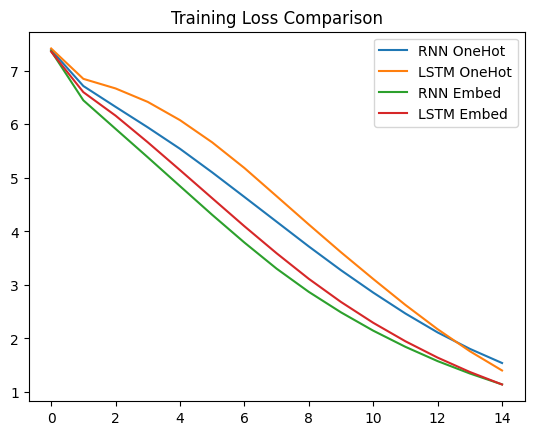

In [ ]:
plt.plot(loss_rnn_onehot, label="RNN OneHot")
plt.plot(loss_lstm_onehot, label="LSTM OneHot")
plt.plot(loss_rnn_embed, label="RNN Embed")
plt.plot(loss_lstm_embed, label="LSTM Embed")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()